In [1]:
from __future__ import print_function
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

In [2]:
print (pyspark.__version__)

2.3.0


In [3]:
n_samples=1000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=5, n_features=n_features, random_state=1)

pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'r' + pddf.index.astype(str)

cols = list(pddf.columns)

cols.insert(0, cols.pop(cols.index('id')))

pddf = pddf.loc[:, cols]
pddf.head(5)
pddf.to_csv('input.csv', index=False)

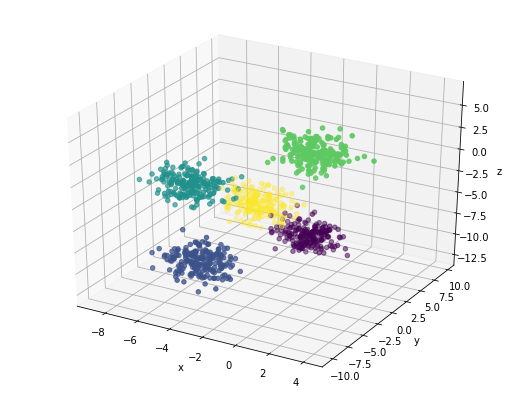

In [4]:
D3plot = plt.figure(figsize=(9,7)).gca(projection='3d')
D3plot.scatter(X[:,0], X[:,1], X[:,2], c=y)
D3plot.set_xlabel('x')
D3plot.set_ylabel('y')
D3plot.set_zlabel('z')
plt.show()

In [6]:
sc = SparkContext(appName="k-means")
sqlContext = SQLContext(sc)

In [7]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'
df = sqlContext.read.csv(path, header=True)
df.show()

+---+-------------------+-------------------+-------------------+
| id|                  x|                  y|                  z|
+---+-------------------+-------------------+-------------------+
| r0|-0.1688509867707031|-3.8108782893580146| 3.5426269193848077|
| r1| -2.477219642972818| -6.473485654084577| -6.304174625049846|
| r2|-0.8427127296993747|  5.590661178767048|-10.202193067806194|
| r3|-2.8885951973894173| -5.939065316258033|-7.3106443197557915|
| r4| -5.468136182574578|  5.082007246005277|-10.553124385127347|
| r5|-1.9859011407730158|   3.69637334946093|-11.001389513629935|
| r6|-5.9558979666731675| -2.980896504348586|-1.9556858049977506|
| r7|-1.4159486713417677| 2.3092492697004046|-10.446343137991041|
| r8|  -7.22893502397076|-3.1184592381899545|-3.7217365182406645|
| r9|-3.0054774340971604| -6.402707762344807|  -8.27898760131139|
|r10| 1.6232500153889684| -3.068897024785516|  4.532749532237625|
|r11|-2.6043589391471578| -5.705283014425677| -7.727494474072648|
|r12| -5.5

In [8]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+---+-----------+----------+-----------+
| id|          x|         y|          z|
+---+-----------+----------+-----------+
| r0|-0.16885099|-3.8108783|  3.5426269|
| r1| -2.4772196|-6.4734855| -6.3041744|
| r2| -0.8427127|  5.590661| -10.202193|
| r3|  -2.888595|-5.9390655|  -7.310644|
| r4| -5.4681363| 5.0820074| -10.553124|
| r5| -1.9859011| 3.6963735|-11.0013895|
| r6|  -5.955898|-2.9808965| -1.9556859|
| r7| -1.4159486| 2.3092492| -10.446343|
| r8| -7.2289352|-3.1184592| -3.7217364|
| r9| -3.0054774|-6.4027076|  -8.278988|
|r10|    1.62325| -3.068897|  4.5327497|
|r11|  -2.604359| -5.705283| -7.7274942|
|r12|  -5.562053|  9.637163|  -9.612745|
|r13| 0.91653746|-1.6709346|  3.6794908|
|r14|  0.8496617|-2.5972176|   4.982598|
|r15| -2.8423986| 3.8013883| -10.751687|
|r16|  -6.168462|-2.4716928| -1.7887893|
|r17| -5.7129197|  8.089075|  -9.817334|
|r18|  2.1246576|-0.9166344|   3.548802|
|r19| -3.8843656|  -7.51934|  -7.691799|
+---+-----------+----------+-----------+
only showing top

In [9]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| r0|[-0.1688509881496...|
| r1|[-2.4772195816040...|
| r2|[-0.8427127003669...|
| r3|[-2.8885951042175...|
| r4|[-5.4681363105773...|
| r5|[-1.9859011173248...|
| r6|[-5.9558978080749...|
| r7|[-1.4159486293792...|
| r8|[-7.2289352416992...|
| r9|[-3.0054774284362...|
|r10|[1.62325000762939...|
|r11|[-2.6043589115142...|
|r12|[-5.5620532035827...|
|r13|[0.91653746366500...|
|r14|[0.84966170787811...|
|r15|[-2.8423986434936...|
|r16|[-6.1684617996215...|
|r17|[-5.7129197120666...|
|r18|[2.12465763092041...|
|r19|[-3.8843655586242...|
+---+--------------------+
only showing top 20 rows



In [10]:
cost = np.zeros(10)
for k in range(2, 10):
    kmeans = KMeans().setK(k).setSeed(2).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False, 0.1, seed=1))
    cost[k] = model.computeCost(df_kmeans)

Text(0,0.5,'cost')

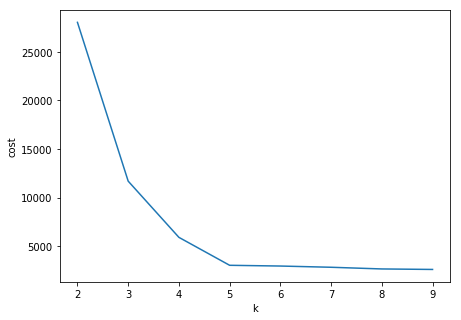

In [11]:
fig, ax = plt.subplots(1,1, figsize =(7,5))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [12]:
# Use elbow method to choose k
k = 5
kmeans = KMeans().setK(k).setSeed(2).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

In [13]:
# Assign membership using tranform method
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:5])

[Row(id='r0', prediction=2), Row(id='r1', prediction=3), Row(id='r2', prediction=4), Row(id='r3', prediction=3), Row(id='r4', prediction=0)]


In [14]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+---+----------+
| id|prediction|
+---+----------+
| r0|         2|
| r1|         3|
| r2|         4|
| r3|         3|
| r4|         0|
| r5|         4|
| r6|         1|
| r7|         4|
| r8|         1|
| r9|         3|
|r10|         2|
|r11|         3|
|r12|         0|
|r13|         2|
|r14|         2|
|r15|         4|
|r16|         1|
|r17|         0|
|r18|         2|
|r19|         3|
+---+----------+
only showing top 20 rows



In [15]:
df_pred = df_pred.join(df, 'id')
df_pred.show()

+---+----------+-----------+----------+-----------+
| id|prediction|          x|         y|          z|
+---+----------+-----------+----------+-----------+
| r0|         2|-0.16885099|-3.8108783|  3.5426269|
| r1|         3| -2.4772196|-6.4734855| -6.3041744|
| r2|         4| -0.8427127|  5.590661| -10.202193|
| r3|         3|  -2.888595|-5.9390655|  -7.310644|
| r4|         0| -5.4681363| 5.0820074| -10.553124|
| r5|         4| -1.9859011| 3.6963735|-11.0013895|
| r6|         1|  -5.955898|-2.9808965| -1.9556859|
| r7|         4| -1.4159486| 2.3092492| -10.446343|
| r8|         1| -7.2289352|-3.1184592| -3.7217364|
| r9|         3| -3.0054774|-6.4027076|  -8.278988|
|r10|         2|    1.62325| -3.068897|  4.5327497|
|r11|         3|  -2.604359| -5.705283| -7.7274942|
|r12|         0|  -5.562053|  9.637163|  -9.612745|
|r13|         2| 0.91653746|-1.6709346|  3.6794908|
|r14|         2|  0.8496617|-2.5972176|   4.982598|
|r15|         4| -2.8423986| 3.8013883| -10.751687|
|r16|       

In [16]:
# Convert prediction to Pandas dataframe for plotting
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
r0,2,-0.168851,-3.810878,3.542627
r1,3,-2.477220,-6.473485,-6.304174
r2,4,-0.842713,5.590661,-10.202193
r3,3,-2.888595,-5.939065,-7.310644
r4,0,-5.468136,5.082007,-10.553124


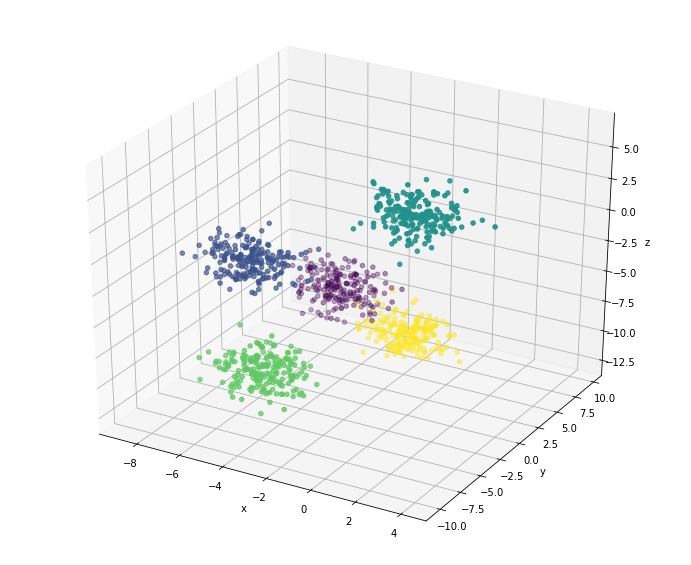

In [17]:
D3plot = plt.figure(figsize=(12,10)).gca(projection='3d')
D3plot.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
D3plot.set_xlabel('x')
D3plot.set_ylabel('y')
D3plot.set_zlabel('z')
plt.show()

In [18]:
sc.stop()